In [1]:
import numpy as np

from primitives.kernels import SquaredExponentialKernel, WhiteKernel
from primitives.means import ZeroMeanFunction
from primitives.proposals import FoldedLaplaceProposalGenerator, FoldedGaussianProposalGenerator
from primitives.priors import InverseGammaPrior

from models import NonGaussianProcess, GaussianProcess
from methods import MH_Within_Gibbs_sampler_for_NGP, MH_Within_Gibbs_sampler_for_GP_parameters

from primitives.levyprocess import GammaProcess
from primitives.levyprocess import TemperedStableProcess

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data_df = pd.read_csv("datasets/ngp_ts/data.csv")
print(data_df)

     Unnamed: 0         X        fX         y
0             0   0.00000 -0.145022 -0.153518
1             1   0.01001 -0.143332 -0.128030
2             2   0.02002 -0.143332 -0.289434
3             3   0.03003 -0.143332 -0.199430
4             4   0.04004 -0.096232  0.020550
..          ...       ...       ...       ...
995         995   9.95996 -0.369058 -0.532689
996         996   9.96997 -0.356892 -0.416621
997         997   9.97998 -0.356892 -0.445346
998         998   9.98999 -0.356892 -0.473832
999         999  10.00000 -0.356892 -0.327533

[1000 rows x 4 columns]


In [3]:
subordinator_data_df = pd.read_csv("datasets/ngp_ts/subordinator_data.csv")
print(subordinator_data_df)

     Unnamed: 0   t_series   x_series
0             0   4.321927  55.446423
1             1   5.874101   4.860160
2             2   8.833160   4.775010
3             3   0.433421   4.230787
4             4   5.129554   3.496162
..          ...        ...        ...
592         592   9.865772   0.307405
593         593   9.899329   0.340253
594         594   9.932886   0.281693
595         595   9.966443   0.290168
596         596  10.000000   0.329578

[597 rows x 3 columns]


In [4]:
def create_training_df(df, outer_interval, inner_interval):
    def set_difference(A, B):
        set_list = []
        set_list.append( (A[0], B[0]) )
        set_list.append( (B[1], A[1]) )
        return set_list

    training_df = pd.DataFrame()

    if inner_interval is None:
        training_df = df[(outer_interval[0] < df["X"]) & (df["X"] < outer_interval[1])]

    else:
        training_intervals = set_difference(outer_interval, inner_interval)
        for interval in training_intervals:
            training_df = pd.concat([training_df, df[(interval[0] < df["X"]) & (df["X"] < interval[1])]])

    return training_df

In [5]:
training_data_df = create_training_df(data_df, (0, 1), None)
print("Number of data points:", training_data_df.index.size)

Number of data points: 99


In [6]:
X = training_data_df["X"].values.reshape(-1, 1)
fX = training_data_df["fX"].values.reshape(-1, 1)
y = training_data_df["y"].values.reshape(-1, 1)

In [7]:
evaluation_interval = (0, 1)
evaluation_data_df = data_df[(evaluation_interval[0] < data_df["X"]) & (data_df["X"] < evaluation_interval[1])]
print("Number of data points:", evaluation_data_df.index.size)

Number of data points: 99


In [8]:
Xeval = evaluation_data_df["X"].values.reshape(-1, 1)
fXeval = evaluation_data_df["fX"].values.reshape(-1, 1)
yeval = evaluation_data_df["y"].values.reshape(-1, 1)

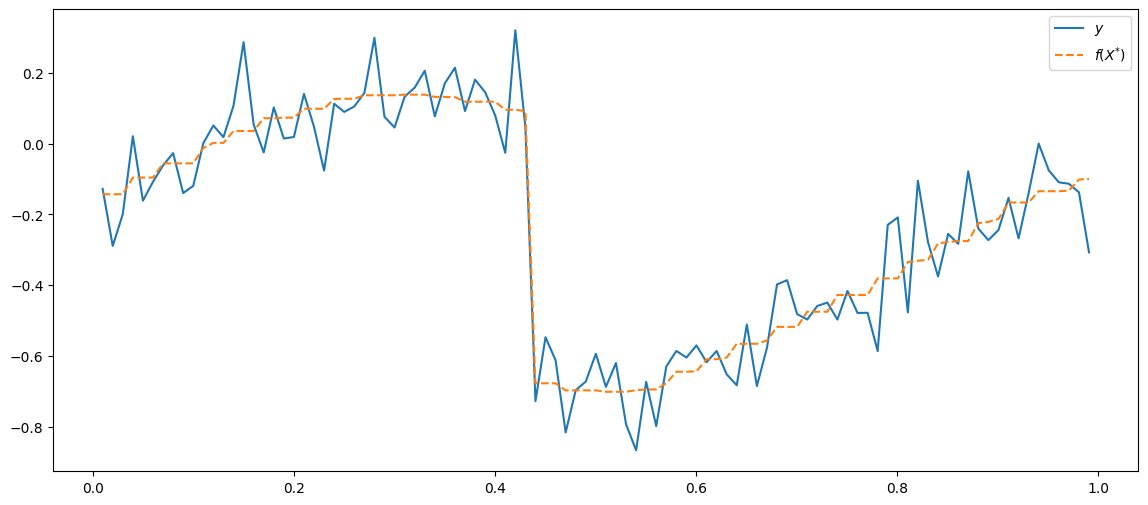

In [9]:
fig, ax = plt.subplots(figsize=(14,6))

ax.plot(Xeval, yeval, label=r'$y$')
ax.plot(Xeval, fXeval, label=r'$f(X^{*})$', ls='--')

ax.legend(fontsize=10)
plt.show()

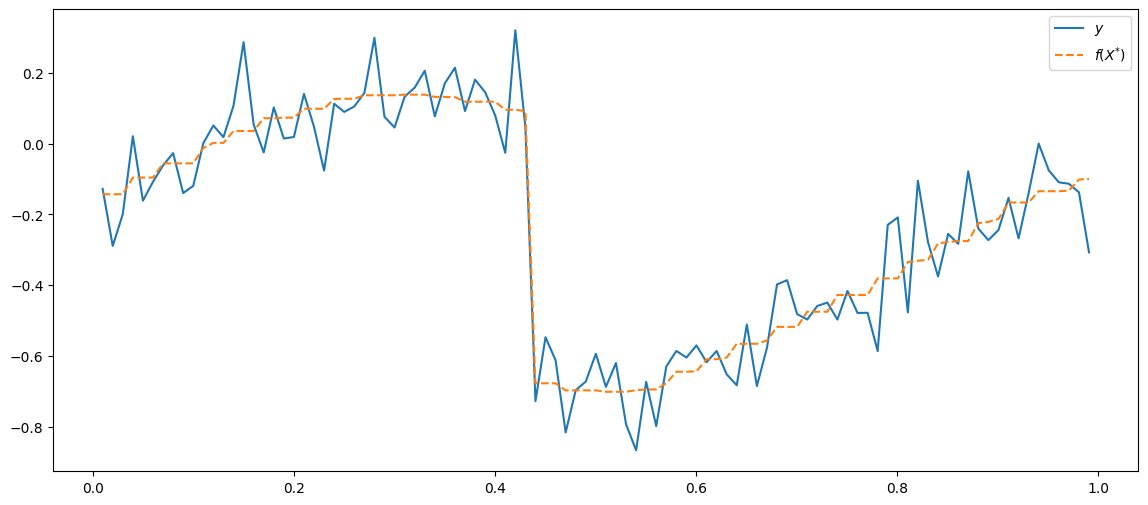

In [10]:
fig, ax = plt.subplots(figsize=(14,6))

ax.plot(X, y, label=r'$y$')
ax.plot(X, fX, label=r'$f(X^{*})$', ls='--')

ax.legend(fontsize=10)
plt.show()

# Gaussian process regression:

In [12]:
# Set proposal object:
sigma_folded_gaussian_proposal_parameters = {"sigma":0.5}
sigma_folded_gaussian_proposal = FoldedGaussianProposalGenerator(**sigma_folded_gaussian_proposal_parameters)

length_scale_folded_gaussian_proposal_parameters = {"sigma":0.1}
length_scale_folded_gaussian_proposal = FoldedGaussianProposalGenerator(**length_scale_folded_gaussian_proposal_parameters)

proposal = {"sigma":sigma_folded_gaussian_proposal, "length_scale":length_scale_folded_gaussian_proposal}

# Set prior object:
sigma_invgamma_prior_parameters = {"alpha":1, "beta":1}
sigma_invgamma_prior = InverseGammaPrior(**sigma_invgamma_prior_parameters)

length_scale_invgamma_prior_parameters = {"alpha":1, "beta":1}
length_scale_invgamma_prior = InverseGammaPrior(**length_scale_invgamma_prior_parameters)

prior = {"sigma":sigma_invgamma_prior, "length_scale":length_scale_invgamma_prior}

# Set initial GP model:
GP_kernel_params = {"sigma":5, "length_scale":10}
GP_kernel_function = SquaredExponentialKernel(**GP_kernel_params)

GP_noise_kernel_function = WhiteKernel(sigma=0.1)
GP_mean_function = ZeroMeanFunction()

GP_model = GaussianProcess(GP_mean_function, GP_kernel_function, GP_noise_kernel_function)

In [13]:
inference_module = MH_Within_Gibbs_sampler_for_GP_parameters(model=GP_model, prior=prior, proposal=proposal)

In [14]:
history = inference_module.fit(y, X, Xeval, n_samples=2000)

<Axes: >

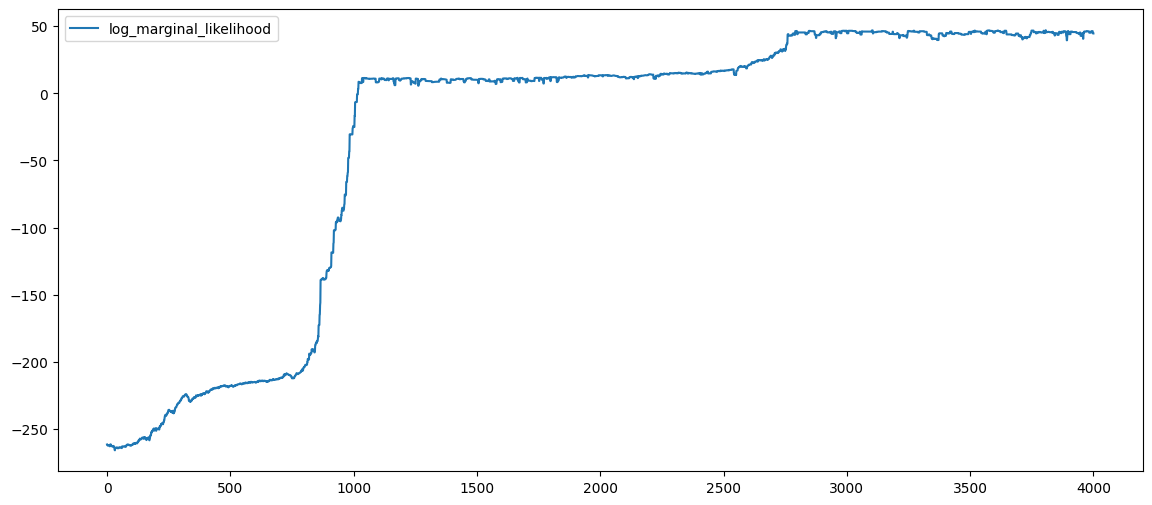

In [15]:
pd.DataFrame.from_records(history, columns=["log_marginal_likelihood"]).explode("log_marginal_likelihood").explode("log_marginal_likelihood").plot(figsize=(14,6))

In [16]:
burn_in = 3000

log_marginal_likelihood    44.881623
dtype: object


<Axes: >

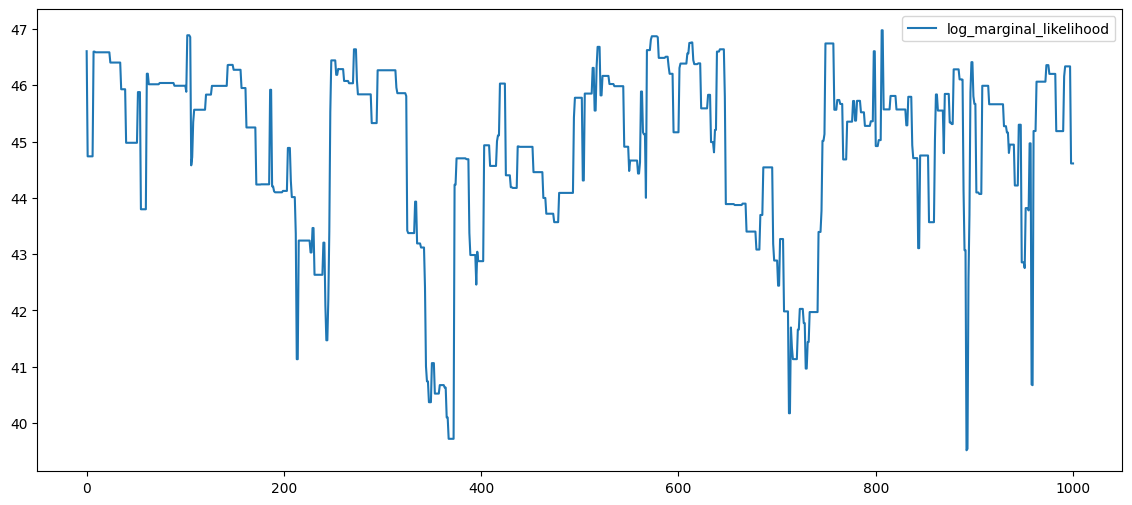

In [17]:
print(pd.DataFrame.from_records(history[burn_in:], columns=["log_marginal_likelihood"]).explode("log_marginal_likelihood").explode("log_marginal_likelihood").mean())

pd.DataFrame.from_records(history[burn_in:], columns=["log_marginal_likelihood"]).explode("log_marginal_likelihood").explode("log_marginal_likelihood").plot(figsize=(14,6))

In [18]:
print(pd.DataFrame.from_records(history[burn_in:], columns=["sigma", "length_scale"]).mean().to_dict())

{'sigma': 0.4616288493783314, 'length_scale': 0.10735542012444829}


<Axes: >

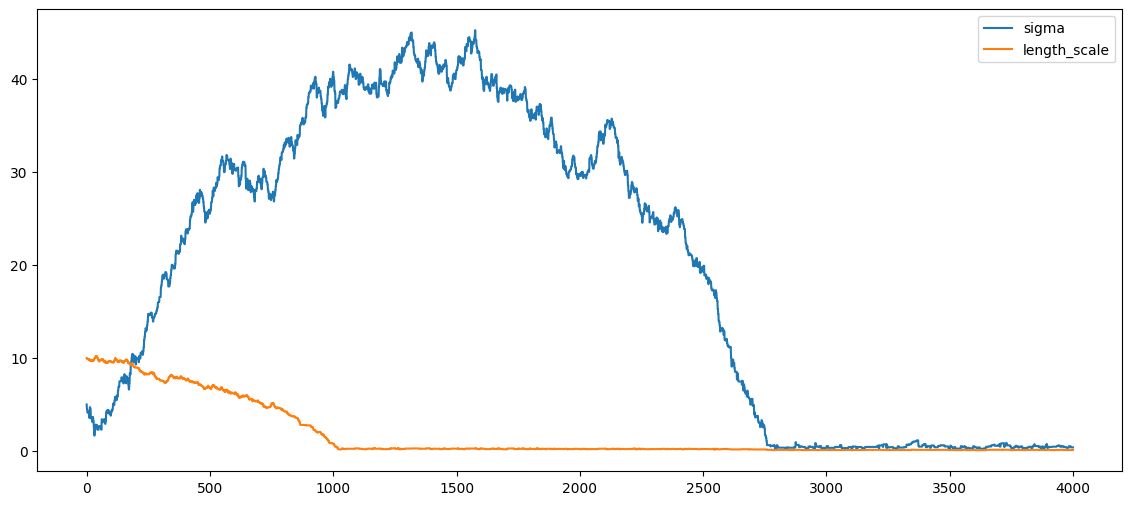

In [19]:
pd.DataFrame.from_records(history, columns=["sigma", "length_scale"]).plot(figsize=(14,6))

In [20]:
GP_model.set_parameter_values(**pd.DataFrame.from_records(history[burn_in:], columns=["sigma", "length_scale"]).mean().to_dict())

In [21]:
post_mean2, post_cov2, log_marginal_likelihood2 = GP_model.posterior_density(y, X, Xeval)

post_std2 = np.sqrt(np.diag(post_cov2))
pred_std2 = np.sqrt(np.diag(post_cov2 + GP_noise_kernel_function(Xeval)))

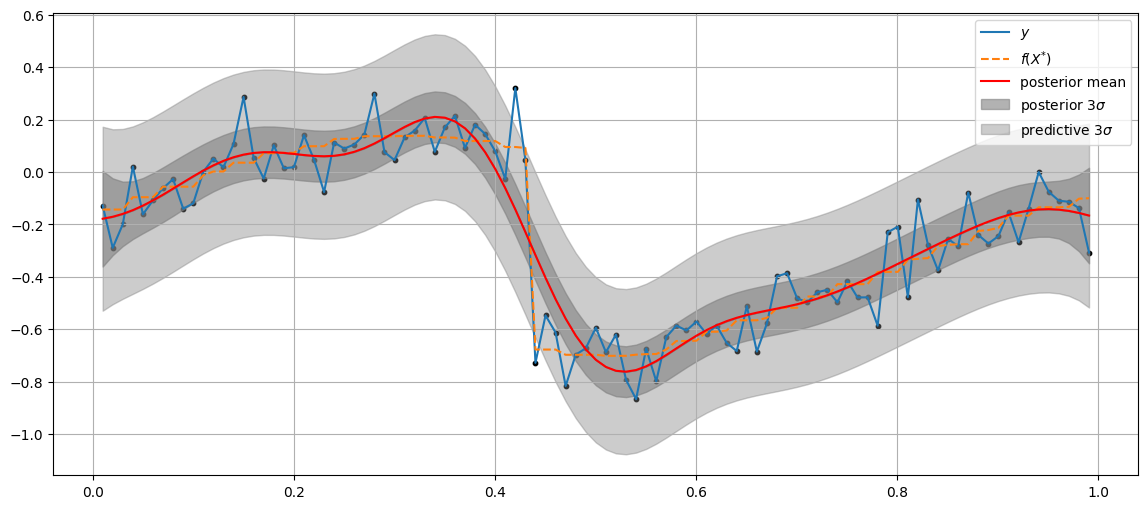

In [22]:
fig, ax = plt.subplots(figsize=(14,6))

ax.scatter(X.flatten(), y.flatten(), s=10, color='black')

ax.plot(Xeval, yeval, label=r'$y$')
ax.plot(Xeval, fXeval, label=r'$f(X^{*})$', ls='--')

ax.plot(Xeval, post_mean2, label='posterior mean', color='red')

ax.fill_between(Xeval.ravel(), post_mean2.ravel(), post_mean2.ravel() + 3*post_std2, alpha=0.6, color='grey', label=r'posterior 3$\sigma$')
ax.fill_between(Xeval.ravel(), post_mean2.ravel(), post_mean2.ravel() - 3*post_std2, alpha=0.6, color='grey')

ax.fill_between(Xeval.ravel(), post_mean2.ravel(), post_mean2.ravel() + 3*pred_std2, alpha=0.4, color='grey', label=r'predictive 3$\sigma$')
ax.fill_between(Xeval.ravel(), post_mean2.ravel(), post_mean2.ravel() - 3*pred_std2, alpha=0.4, color='grey')

ax.grid(True)
ax.legend(fontsize=10)
plt.show()

# Non-Gaussian process regression:

In [23]:
# Set proposal object:
# sigma_folded_gaussian_proposal_parameters = {"sigma":0.1}
# sigma_folded_gaussian_proposal = FoldedGaussianProposalGenerator(**sigma_folded_gaussian_proposal_parameters)

sigma_folded_laplace_proposal_parameters = {"sigma":0.1}
sigma_folded_laplace_proposal = FoldedLaplaceProposalGenerator(**sigma_folded_laplace_proposal_parameters)

# length_scale_folded_gaussian_proposal_parameters = {"sigma":0.1}
# length_scale_folded_gaussian_proposal = FoldedGaussianProposalGenerator(**length_scale_folded_gaussian_proposal_parameters)

length_scale_folded_laplace_proposal_parameters = {"sigma":0.1}
length_scale_folded_laplace_proposal = FoldedLaplaceProposalGenerator(**length_scale_folded_laplace_proposal_parameters)

proposal = {"sigma":sigma_folded_laplace_proposal, "length_scale":length_scale_folded_laplace_proposal}

# Set prior object:
sigma_invgamma_prior_parameters = {"alpha":1, "beta":1}
sigma_invgamma_prior = InverseGammaPrior(**sigma_invgamma_prior_parameters)

length_scale_invgamma_prior_parameters = {"alpha":1, "beta":1}
length_scale_invgamma_prior = InverseGammaPrior(**length_scale_invgamma_prior_parameters)

prior = {"sigma":sigma_invgamma_prior, "length_scale":length_scale_invgamma_prior}

# # Gamma subordinator:
# NGP_subordinator = GammaProcess(**gamma_process_params)
# Tempered stable subordinator:
TS_process_params = {"alpha":0.7, "beta":0.01, "C":1.}
NGP_subordinator = TemperedStableProcess(**TS_process_params)

# Set initial NGP model:
NGP_kernel_params = {"sigma":5, "length_scale":10}
NGP_kernel_function = SquaredExponentialKernel(**NGP_kernel_params)

NGP_noise_kernel_function = WhiteKernel(sigma=0.1)
NGP_mean_function = ZeroMeanFunction()

NGP_model = NonGaussianProcess(NGP_mean_function, NGP_kernel_function, NGP_noise_kernel_function, subordinator=NGP_subordinator)

Residual approximation mode is set to Gaussian approximation.


In [24]:
inference_module = MH_Within_Gibbs_sampler_for_NGP(model=NGP_model, prior=prior, proposal=proposal)

In [25]:
history = inference_module.fit(y, X, Xeval, n_samples=2000, n_intervals=20)

In [26]:
results_df = pd.DataFrame(history)

<Axes: >

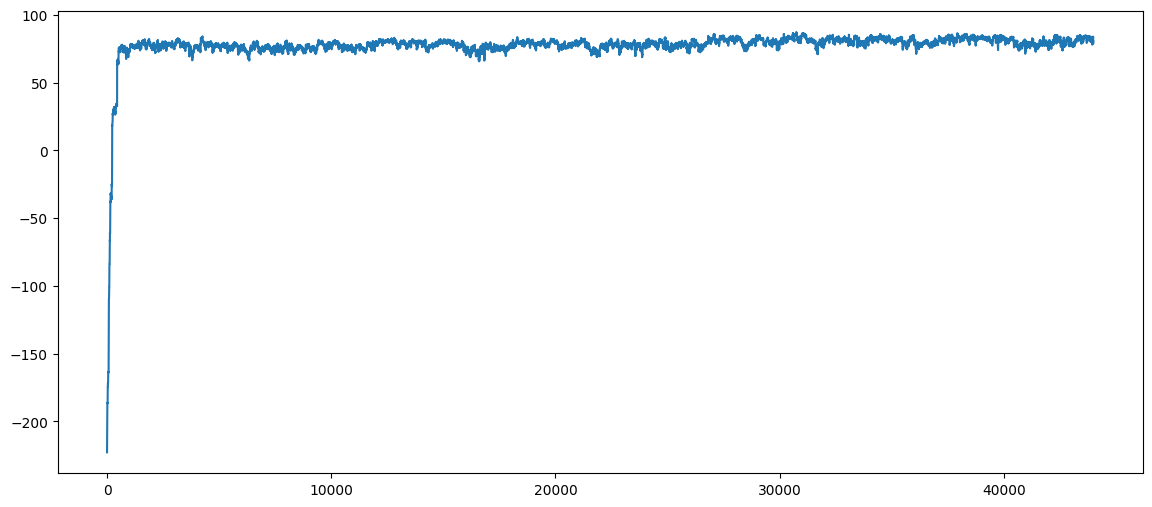

In [27]:
results_df["log_marginal_likelihood"].explode().explode().plot(figsize=(14,6))

sigma           2.890916
length_scale    5.604010
dtype: float64


<Axes: >

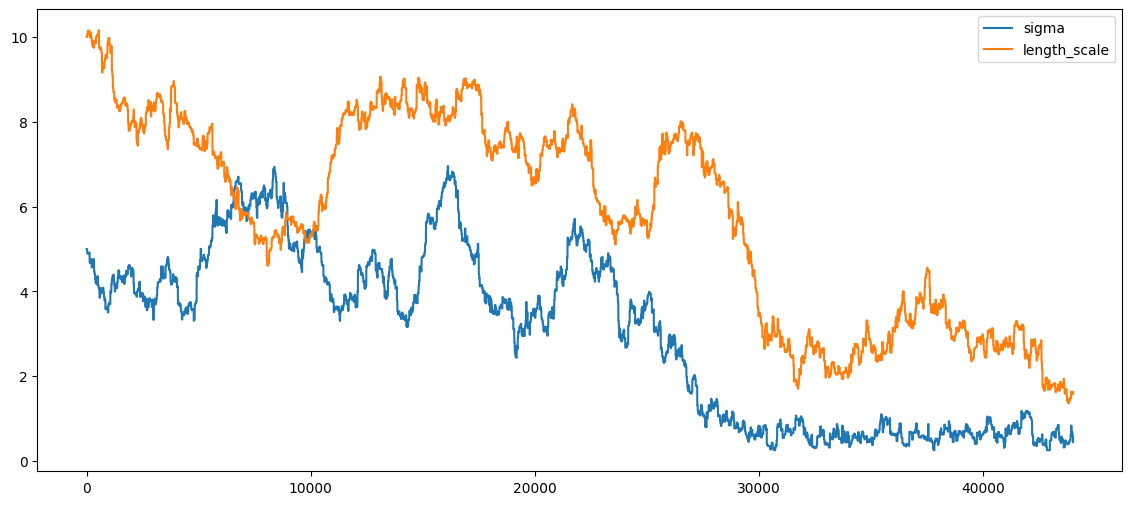

In [28]:
print(results_df[["sigma", "length_scale"]][burn_in:].mean())
results_df[["sigma", "length_scale"]].plot(figsize=(14,6))

In [29]:
burn_in = 30_000

In [30]:
results_df["log_marginal_likelihood"].explode().explode()[burn_in:].mean()

80.93420574010332

<Axes: >

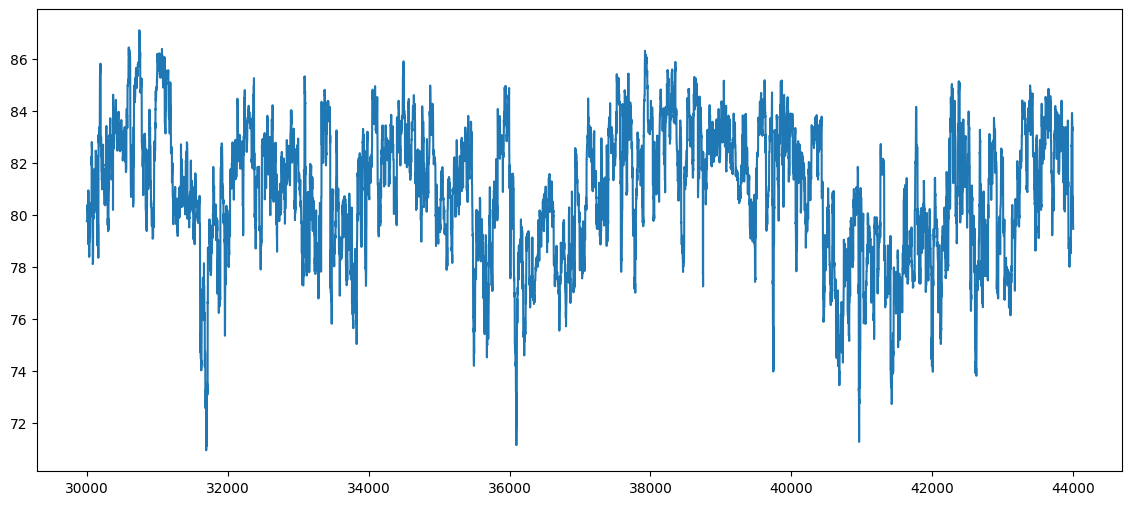

In [31]:
results_df["log_marginal_likelihood"].explode().explode()[burn_in:].plot(figsize=(14,6))

In [32]:
post_mean = results_df["mean"][burn_in:].mean()

In [33]:
tmp = (pd.DataFrame(np.hstack(results_df["mean"][burn_in:].values)) - post_mean).values
mixture_adjustment = np.matmul(tmp, tmp.T) / results_df["mean"][burn_in:].shape[0]
post_cov = results_df["cov"][burn_in:].sum(axis=0)/results_df["cov"][burn_in:].shape[0] + mixture_adjustment

In [34]:
post_f_std = np.sqrt(np.diag(post_cov))
post_y_std = np.sqrt(np.diag(post_cov + NGP_noise_kernel_function(Xeval)))

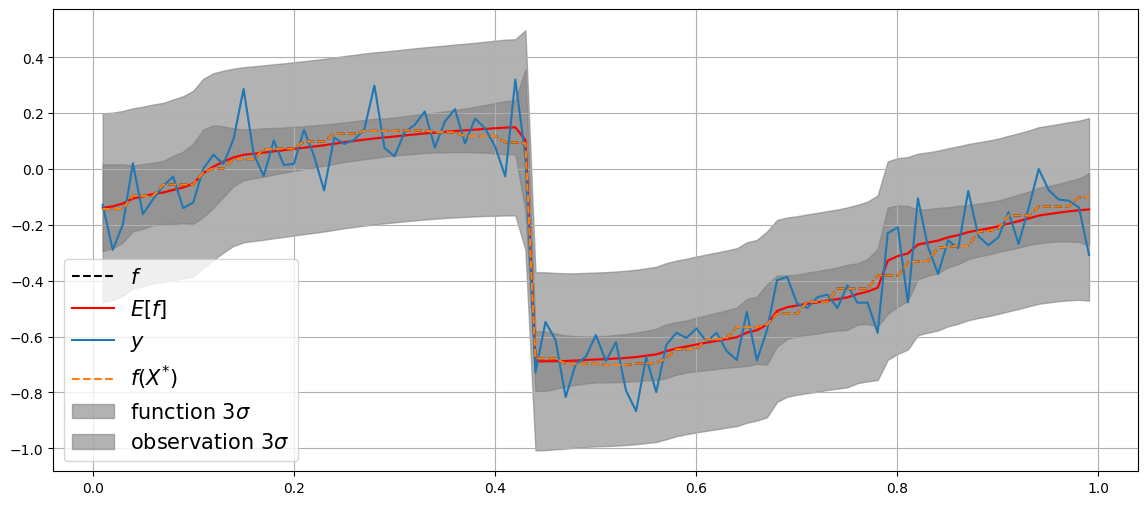

In [35]:
fig, ax = plt.subplots(figsize=(14,6))

ax.plot(X, fX, label=r'$f$', color='black', ls='--')
#ax.plot(X, y, label='y')

ax.plot(Xeval, post_mean, label=r'$E[f]$', color='red')
ax.plot(Xeval, yeval, label=r'$y$')
ax.plot(Xeval, fXeval, label=r'$f(X^{*})$', ls='--')


ax.fill_between(Xeval.ravel(), post_mean.ravel(), post_mean.ravel() + 3 * post_f_std, alpha=0.6, color='grey', label=r'function 3$\sigma$')
ax.fill_between(Xeval.ravel(), post_mean.ravel(), post_mean.ravel() - 3 * post_f_std, alpha=0.6, color='grey')

ax.fill_between(Xeval.ravel(), post_mean.ravel(), post_mean.ravel() + 3 * post_y_std, alpha=0.6, color='grey', label=r'observation 3$\sigma$')
ax.fill_between(Xeval.ravel(), post_mean.ravel(), post_mean.ravel() - 3 * post_y_std, alpha=0.6, color='grey')

ax.grid(True)
ax.legend(fontsize=15)
plt.show()

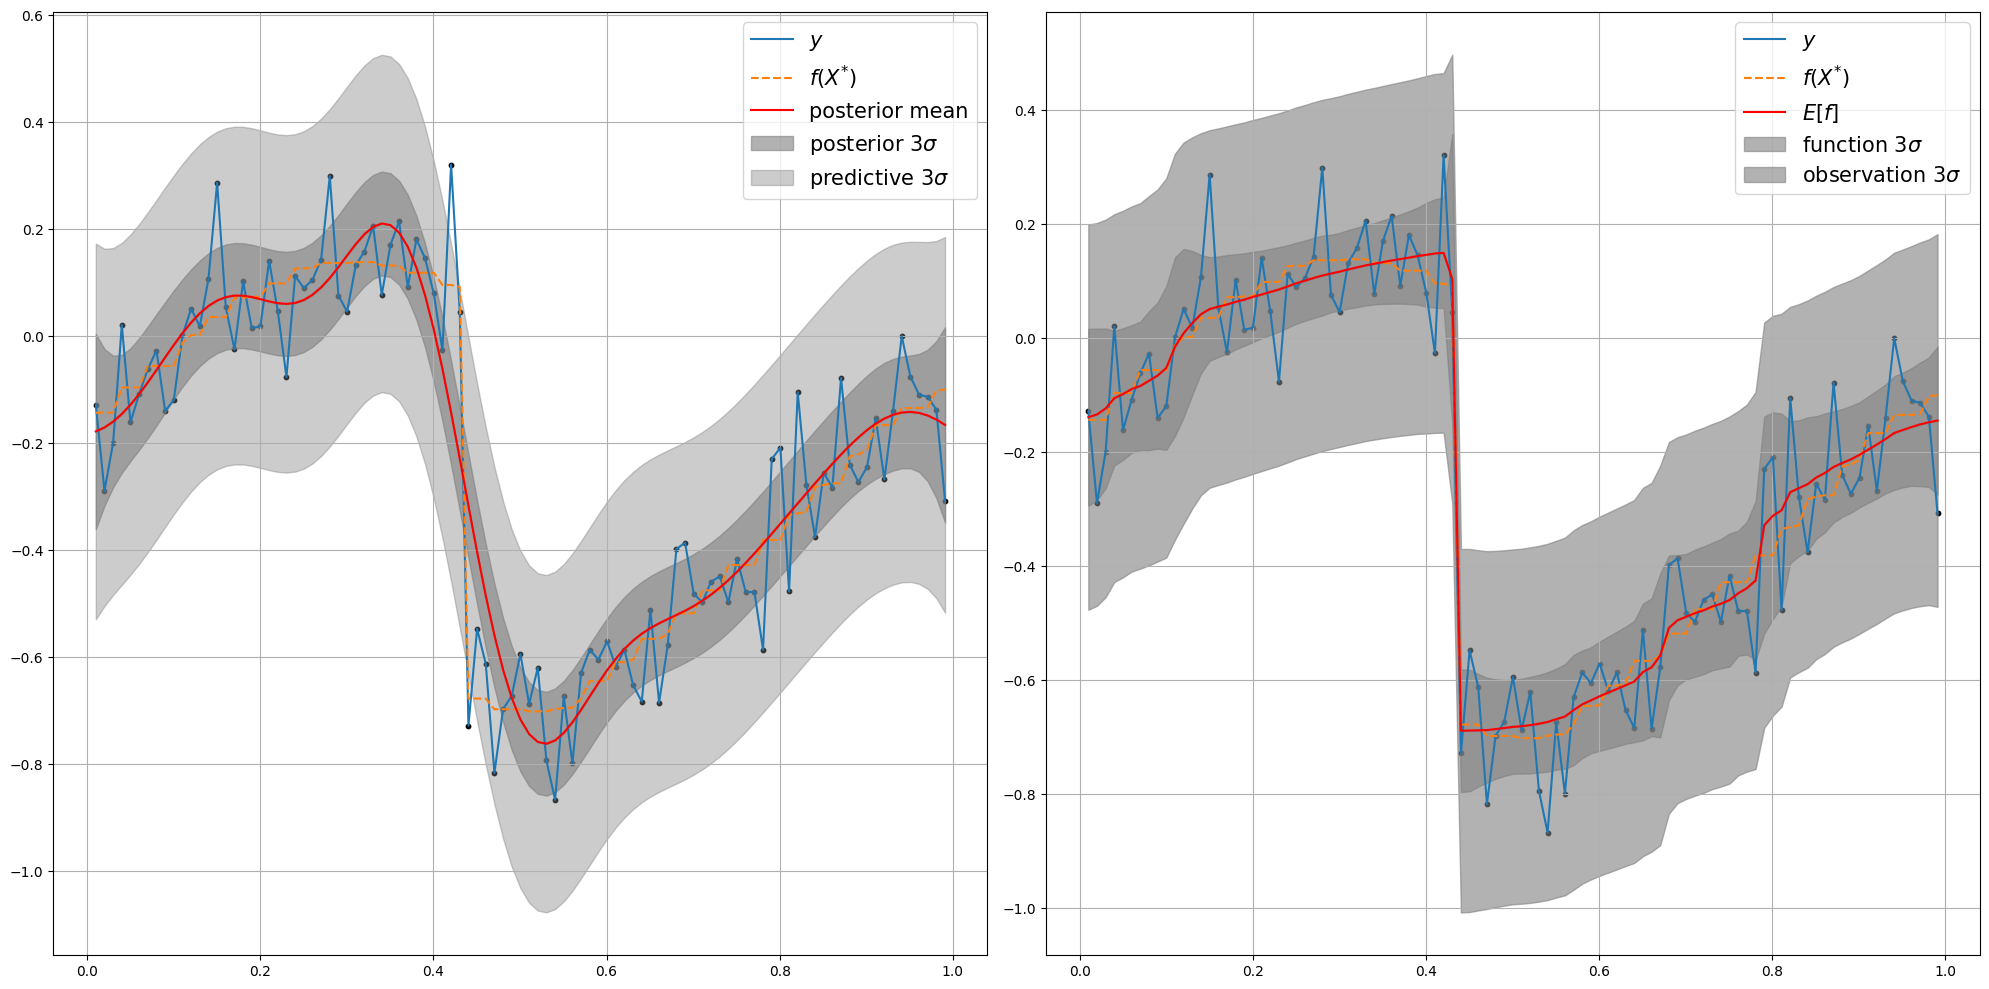

In [41]:
fig, ax = plt.subplots(ncols=2, figsize=(20,10))

ax[0].scatter(X.flatten(), y.flatten(), s=10, color='black')

ax[0].plot(Xeval, yeval, label=r'$y$')
ax[0].plot(Xeval, fXeval, label=r'$f(X^{*})$', ls='--')

ax[0].plot(Xeval, post_mean2, label='posterior mean', color='red')

ax[0].fill_between(Xeval.ravel(), post_mean2.ravel(), post_mean2.ravel() + 3*post_std2, alpha=0.6, color='grey', label=r'posterior 3$\sigma$')
ax[0].fill_between(Xeval.ravel(), post_mean2.ravel(), post_mean2.ravel() - 3*post_std2, alpha=0.6, color='grey')

ax[0].fill_between(Xeval.ravel(), post_mean2.ravel(), post_mean2.ravel() + 3*pred_std2, alpha=0.4, color='grey', label=r'predictive 3$\sigma$')
ax[0].fill_between(Xeval.ravel(), post_mean2.ravel(), post_mean2.ravel() - 3*pred_std2, alpha=0.4, color='grey')

ax[0].grid(True)
ax[0].legend(fontsize=15)


ax[1].scatter(X.flatten(), y.flatten(), s=10, color='black')

ax[1].plot(Xeval, yeval, label=r'$y$')
ax[1].plot(Xeval, fXeval, label=r'$f(X^{*})$', ls='--')

ax[1].plot(Xeval, post_mean, label=r'$E[f]$', color='red')

ax[1].fill_between(Xeval.ravel(), post_mean.ravel(), post_mean.ravel() + 3 * post_f_std, alpha=0.6, color='grey', label=r'function 3$\sigma$')
ax[1].fill_between(Xeval.ravel(), post_mean.ravel(), post_mean.ravel() - 3 * post_f_std, alpha=0.6, color='grey')

ax[1].fill_between(Xeval.ravel(), post_mean.ravel(), post_mean.ravel() + 3 * post_y_std, alpha=0.6, color='grey', label=r'observation 3$\sigma$')
ax[1].fill_between(Xeval.ravel(), post_mean.ravel(), post_mean.ravel() - 3 * post_y_std, alpha=0.6, color='grey')

ax[1].grid(True)
ax[1].legend(fontsize=15)

plt.tight_layout()
plt.show()

In [37]:
results_subordinator_df = results_df[["t_series", "x_series"]][burn_in:].dropna()
results_subordinator_df = results_subordinator_df.apply(lambda x: NGP_model.subordinator.stochastic_integral(evaluation_points=Xeval, t_series=x.t_series, x_series=x.x_series).flatten(),
                                                        axis=1,
                                                        result_type="expand") 
sub_burn_in = results_subordinator_df.shape[0]-200

<Axes: >

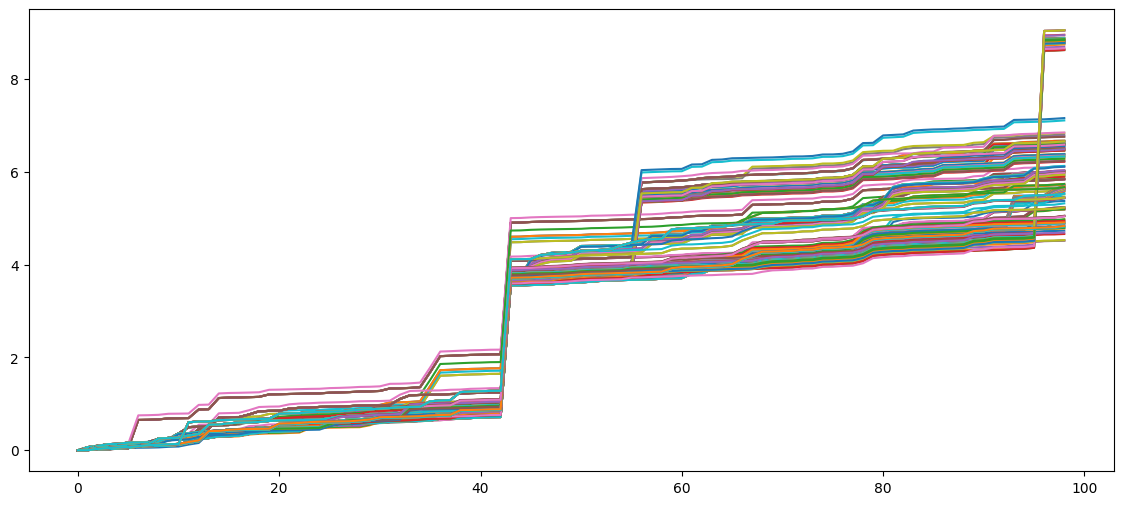

In [38]:
results_subordinator_df.iloc[sub_burn_in:].T.plot(figsize=(14,6), legend=False)

In [39]:
Wx = results_subordinator_df.iloc[sub_burn_in:].T.values

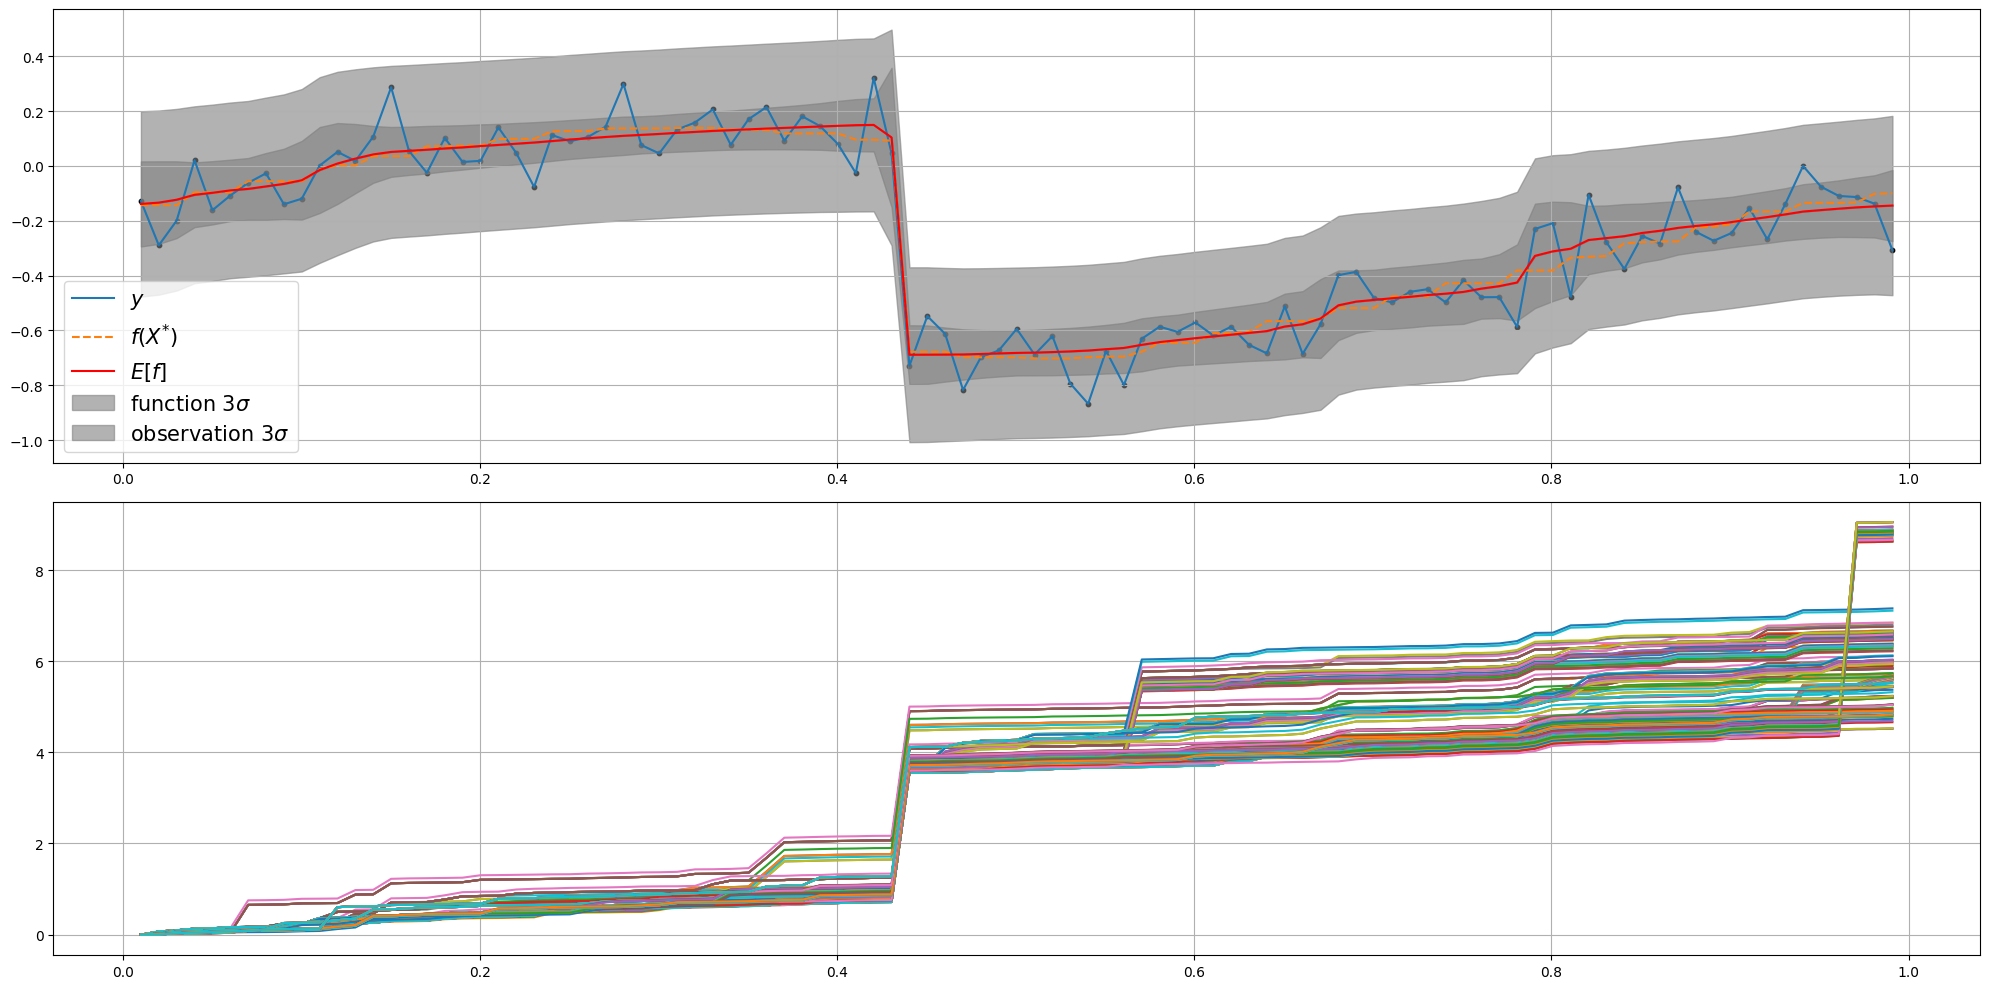

In [40]:
fig, ax = plt.subplots(nrows=2, figsize=(20,10))

ax[0].scatter(X.flatten(), y.flatten(), s=10, color='black')

ax[0].plot(Xeval, yeval, label=r'$y$')
ax[0].plot(Xeval, fXeval, label=r'$f(X^{*})$', ls='--')

ax[0].plot(Xeval, post_mean, label=r'$E[f]$', color='red')

ax[0].fill_between(Xeval.ravel(), post_mean.ravel(), post_mean.ravel() + 3 * post_f_std, alpha=0.6, color='grey', label=r'function 3$\sigma$')
ax[0].fill_between(Xeval.ravel(), post_mean.ravel(), post_mean.ravel() - 3 * post_f_std, alpha=0.6, color='grey')

ax[0].fill_between(Xeval.ravel(), post_mean.ravel(), post_mean.ravel() + 3 * post_y_std, alpha=0.6, color='grey', label=r'observation 3$\sigma$')
ax[0].fill_between(Xeval.ravel(), post_mean.ravel(), post_mean.ravel() - 3 * post_y_std, alpha=0.6, color='grey')

ax[0].grid(True)
ax[0].legend(fontsize=15)


ax[1].plot(Xeval, Wx)
ax[1].grid(True)

plt.tight_layout()
plt.show()